## Lecture2: Calculations using PyCalphad

### Outline
1. [Calculate activity using pycalphad: equilibirum function in pycalphad](#Activity-calculation)
2. [Calculate phase diagram using pycalphad](#Phase-diagram-calculation)
3. [Prepare input for ESPEI MCMC with xml database](#ESPEI-MCMC)
4. [Uncertainty quantification and propagation](#UQ-and-UP)

### Important notes

* All element and phase names must be capitalized
* Currently, pycalphad take compositions of each element as input
* Output will be normalized in per mol-atom

#### Equilibrium function in pycalphad

The equilibrium() function is responsible for equilibrium property calculation in pycalphad. The key arguments include
- 'dbf', a database file
- 'comps', a list of desired components
- 'phases', a list of desired phases
- 'conds', a dictionary mapping state variables to values, such as temperature (K), pressure (Pa), compositions, it also can be set as a range with start, stop, and steps forms


equilibrium() output
* Coordinates: input variables, including N, P, T, compositions, component. There is no physical meaning of vertex, this coordinate describe the index of the phase in equilibrium.
* Data variables: output variales
    - NP: Phase fraction, mole fraction of each phase, the index is corresponding to vertex and Phase
    - GM: Gibbs energy of the system, J/mol-atom
    - MU: Chemical potential of each component, the index is corresponding to coordinates component index, unit: J/mol-atom
    - X: The mole fraction of each component in each phase, the phase index is correspoding to vertex, the component index is corresponding to coordinates component index
    - Y: The site fraction of each site in each phase, the phase index is correspoding to vertex, the component index is corresponding to internal degree of freedom
    - Phase: The string name of the phase in equilibrium at the conditions, the index is corresponding to vertex

### Activity calculation
#### Calculate activity of KCl in KCl-SrCl2 liquid at 1023K

KCl-SrCl2 database is took from MSTBD-TC V3.0, the original database is from P. Chartrand & A. D. Pelton, https://doi.org/10.1179/cmq.2000.39.4.405

In [1]:
from pycalphad import Database, equilibrium, variables as v
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pycalphad.models.model_mqmqa import ModelMQMQA
import os

dbf=Database('BaCl2-CaCl2-SrCl2-LiCl-NaCl-KCl.xml')
comps = ['K', 'SR', 'CL']
phases = ['MSCL']
#phases = list(dbf.phases.keys()) # a command to automatically read all phases from the database

#### Calculate the reference state
Because all chemical activities must be specified with a reference state, we’re going to choose a reference state which is consistent with the experimental data.

In [2]:
## Calculate equilibrium for KCl reference state in liquid
ref_eq = equilibrium(dbf, ['K', 'CL'], 'MSCL', {v.N: 1, v.P: 101325, v.T: 1023, v.X('K'):0.5})
ref_eq

<xarray.Dataset>
Dimensions:    (N: 1, P: 1, T: 1, X_K: 1, vertex: 3, component: 2,
                internal_dof: 1)
Coordinates:
  * N          (N) float64 1.0
  * P          (P) float64 1.013e+05
  * T          (T) float64 1.023e+03
  * X_K        (X_K) float64 0.5
  * vertex     (vertex) int64 0 1 2
  * component  (component) <U2 'CL' 'K'
Dimensions without coordinates: internal_dof
Data variables:
    NP         (N, P, T, X_K, vertex) float64 1.0 nan nan
    GM         (N, P, T, X_K) float64 -2.749e+05
    MU         (N, P, T, X_K, component) float64 -2.749e+05 -2.749e+05
    X          (N, P, T, X_K, vertex, component) float64 0.5 0.5 nan nan nan nan
    Y          (N, P, T, X_K, vertex, internal_dof) float64 1.0 nan nan
    Phase      (N, P, T, X_K, vertex) <U6 'MSCL' '' ''
Attributes:
    engine:   pycalphad 0.10.2
    created:  2023-11-09T14:36:39.330895

In [11]:
## Try to calculate equilibrium for SrCl2 reference state in liquid at 1023 K


#### Calculate the equilibrium

Perform the calculation over the composition range

In [4]:
def calc_pseudo_comp(species, composition):
    atomic_mole=dict()
    atomic_composition=dict()
    for i in species.keys():
        for j in species[i].keys():
            nmole=species[i][j]*composition[i]
            if j in atomic_mole.keys():
                atomic_mole[j]=atomic_mole[j]+nmole
            else:
                atomic_mole[j]=nmole
    tot_mole=0
    for ele in atomic_mole.keys():
        tot_mole+=atomic_mole[ele]
    for ele in atomic_mole.keys():   
        mole_fraction=atomic_mole[ele]/tot_mole
        atomic_composition[ele]=mole_fraction
    return atomic_composition

In [5]:
species={'SRCL2': {'SR':1, 'CL':2}, 'KCL': {'K':1, 'CL':1}}
composition={'SRCL2': 0.3, 'KCL': 0.7}
atomic_comp=calc_pseudo_comp(species,composition)
atomic_comp

{'SR': 0.13043478260869565, 'CL': 0.5652173913043478, 'K': 0.30434782608695654}

In [6]:
ref_eq = equilibrium(dbf, ['K', 'CL'], 'MSCL', {v.N: 1, v.P: 101325, v.T: 1023, v.X('K'):0.5})
#Equilibrium calculation: x(SrCl2)=0.7, T=1023K
eq = equilibrium(dbf, ['K', 'CL', 'SR'], 'MSCL', {v.N: 1, v.P: 101325, v.T: 1023, v.X('K'): atomic_comp['K'], v.X('SR'): atomic_comp['SR']})
   

In [43]:
chempot_ref = ref_eq.MU.sel(component='K').squeeze()+ref_eq.MU.sel(component='CL').squeeze()
chempot = (eq.MU.sel(component='K').squeeze()+eq.MU.sel(component='CL').squeeze())
acr=np.exp((chempot - chempot_ref)/(8.3145*1023))  # mu=mu_ref+RTln(acr)

print('Calculted activity of KCl at x(KCl)=0.7, T=1023K is', acr.values)
print('Experimental activity of KCl at x(KCl)=0.7, T=1023K is 0.574')

Calculted activity of KCl at x(KCl)=0.7, T=1023K is 0.5670408240401484
Experimental activity of KCl at x(KCl)=0.7, T=1023K is 0.574


In [7]:
# Calculate activity over composition range
Temp=1023
ref_eq = equilibrium(dbf, ['K', 'CL'], 'MSCL', {v.N: 1, v.P: 101325, v.T: Temp, v.X('K'):0.5})
acr_kcl=list()
x_srcl2=np.arange(0.1,1,0.1)
for i in x_srcl2:
    composition={'SRCL2':i, 'KCL':1-i}
    atomic_comp=calc_pseudo_comp(species,composition)
    eq = equilibrium(dbf, ['K', 'CL', 'SR'], 'MSCL', {v.N: 1, v.P: 101325, v.T: Temp, v.X('K'): atomic_comp['K'], v.X('SR'): atomic_comp['SR']})
    chempot_ref = ref_eq.MU.sel(component='K').squeeze()+ref_eq.MU.sel(component='CL').squeeze()
    chempot = (eq.MU.sel(component='K').squeeze()+eq.MU.sel(component='CL').squeeze())
    acr=np.exp((chempot - chempot_ref)/(8.3145*Temp))
    acr_kcl.append(acr.values)


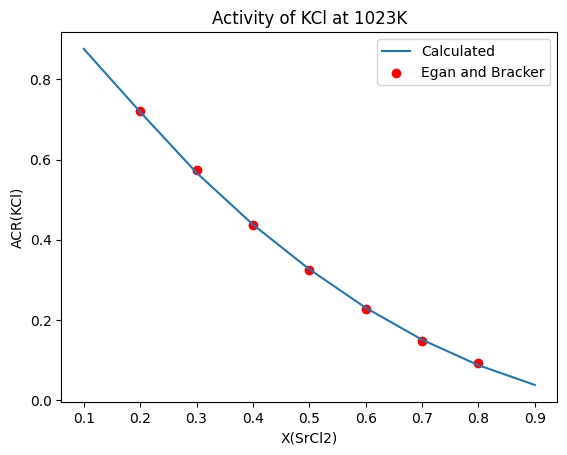

In [8]:
import matplotlib.pyplot as plt
plt.plot(x_srcl2, acr_kcl, label='Calculated')
# add experimental data from Egan and Bracker, https://doi.org/10.1016/0021-9614(74)90201-8
exp_x_srcl2=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
exp_acr_kcl=[0.72, 0.574, 0.436, 0.325, 0.228, 0.147, 0.093]
plt.scatter(exp_x_srcl2, exp_acr_kcl, label='Egan and Bracker', color='red')
plt.xlabel('X(SrCl2)')
plt.ylabel('ACR(KCl)')
plt.title('Activity of KCl at 1023K')
plt.legend(loc=0)
plt.show()

### Phase diagram of KCl-SrCl2

Major functions used to plot pseudo-binary phase diagram is ***equilibirum()*** and ***eqplot()***

In [9]:
"""
Modify eqplot module in pycalphad to plot pseudo-binary, this function only applies to plot pesudo-phase diagram when charge of anions is -1

The eqplot module contains functions for general plotting of
the results of equilibrium calculations.
"""
from pycalphad.core.utils import unpack_condition
from pycalphad.plot.utils import phase_legend
import pycalphad.variables as v
from matplotlib import collections as mc
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict

# TODO: support other state variables here or make isinstance elif == v.T or v.P
_plot_labels = {v.T: 'Temperature (K)', v.P: 'Pressure (Pa)'}


def _axis_label(ax_var):
    if isinstance(ax_var, v.MoleFraction):
        return 'X({})'.format(ax_var.species.name)
    elif isinstance(ax_var, v.StateVariable):
        return _plot_labels[ax_var]
    else:
        return ax_var

def _map_coord_to_variable(coord):
    """
    Map a coordinate to a StateVariable object.

    Parameters
    ----------
    coord : str
        Name of coordinate in equilibrium object.

    Returns
    -------
    pycalphad StateVariable
    """
    vals = {'T': v.T, 'P': v.P}
    if coord.startswith('X_'):
        return v.X(coord[2:])
    elif coord in vals:
        return vals[coord]
    else:
        return coord


def eqplot(eq, ax=None, x=None, y=None, z=None, tielines=True, tieline_color=(0, 1, 0, 1), tie_triangle_color=(1, 0, 0, 1), legend_generator=phase_legend, **kwargs):
    """
    Plot the result of an equilibrium calculation.

    The type of plot is controlled by the degrees of freedom in the equilibrium calculation.

    Parameters
    ----------
    eq : xarray.Dataset
        Result of equilibrium calculation.
    ax : matplotlib.Axes
        Default axes used if not specified.
    x : StateVariable, optional
    y : StateVariable, optional
    z : StateVariable, optional
    tielines : bool
        If True, will plot tielines
    tieline_color: color
        A valid matplotlib color, such as a named color string, hex RGB
        string, or a tuple of RGBA components to set the color of the two
        phase region tielines. The default is an RGBA tuple for green:
        (0, 1, 0, 1).
    tie_triangle_color: color
        A valid matplotlib color, such as a named color string, hex RGB
        string, or a tuple of RGBA components to set the color of the two
        phase region tielines. The default is an RGBA tuple for red:
        (1, 0, 0, 1).
    legend_generator : Callable
        A function that will be called with the list of phases and will
        return legend labels and colors for each phase. By default
        pycalphad.plot.utils.phase_legend is used
    kwargs : kwargs
        Passed to `matplotlib.pyplot.scatter`.

    Returns
    -------
    matplotlib AxesSubplot
    """
    conds = OrderedDict([(_map_coord_to_variable(key), unpack_condition(np.asarray(value)))
                         for key, value in sorted(eq.coords.items(), key=str)
                         if (key in ('T', 'P', 'N')) or (key.startswith('X_'))])
    indep_comps = sorted([key for key, value in conds.items() if isinstance(key, v.MoleFraction) and len(value) > 1], key=str)
    indep_pots = [key for key, value in conds.items() if (type(key) is v.StateVariable) and len(value) > 1]

    # determine what the type of plot will be
    if len(indep_comps) == 1 and len(indep_pots) == 1:
        projection = None
    elif len(indep_comps) == 2 and len(indep_pots) == 0:
        projection = 'triangular'
    else:
        projection = None
    #if z is not None:
    #    raise NotImplementedError('3D plotting is not yet implemented')
    if ax is None:
        fig, (ax) = plt.subplots(subplot_kw={'projection': projection})
    # Handle cases for different plot types
    if projection is None:
        x = indep_comps[0] if x is None else x
        y = indep_pots[0] if y is None else y
        # plot settings
        ax.set_xlim([np.min(conds[x]) - 1e-2, np.max(conds[x]) + 1e-2])
        ax.set_ylim([np.min(conds[y]), np.max(conds[y])])
    elif projection == 'triangular':
        x = indep_comps[0] if x is None else x
        y = indep_comps[1] if y is None else y
        # Here we adjust the x coordinate of the ylabel.
        # We make it reasonably comparable to the position of the xlabel from the xaxis
        # As the figure size gets very large, the label approaches ~0.55 on the yaxis
        # 0.55*cos(60 deg)=0.275, so that is the xcoord we are approaching.
        ax.yaxis.label.set_va('baseline')
        fig_x_size = ax.figure.get_size_inches()[0]
        y_label_offset = 1 / fig_x_size
        ax.yaxis.set_label_coords(x=(0.275 - y_label_offset), y=0.5)

    phases = map(str, sorted(set(np.array(eq.Phase.values.ravel(), dtype='U')) - {''}, key=str))
    comps = map(str, sorted(np.array(eq.coords['component'].values, dtype='U'), key=str))
    eq['component'] = np.array(eq['component'], dtype='U')
    eq['Phase'].values = np.array(eq['Phase'].values, dtype='U')

    # Select all two- and three-phase regions
    three_phase_idx = np.nonzero(np.sum(eq.Phase.values != '', axis=-1, dtype=np.int_) == 3)
    two_phase_idx = np.nonzero(np.sum(eq.Phase.values != '', axis=-1, dtype=np.int_) == 2)

    legend_handles, colorlist = legend_generator(phases)

    # For both two and three phase, cast the tuple of indices to an array and flatten
    # If we found two phase regions:
    if two_phase_idx[0].size > 0:
        found_two_phase = eq.Phase.values[two_phase_idx][..., :2]
        # get tieline endpoint compositions
        two_phase_x = eq.X.sel(component=x.species.name).values[two_phase_idx][..., :2]
        two_phase_z = eq.X.sel(component=z.species.name).values[two_phase_idx][..., :2]
        #print('two_phase_x:', two_phase_x[..., 0])
        # handle special case for potential
        if isinstance(y, v.MoleFraction):
            two_phase_y = eq.X.sel(component=y.species.name).values[two_phase_idx][..., :2]
        else:
            # it's a StateVariable. This must be True
            two_phase_y = np.take(eq[str(y)].values, two_phase_idx[eq.Phase.dims.index(str(y))])

            # because the above gave us a shape of (n,) instead of (n,2) we are going to create it ourselves
            two_phase_y = np.array([two_phase_y, two_phase_y]).swapaxes(0, 1)

        # plot two phase points
        two_phase_plotcolors = np.array(list(map(lambda x: [colorlist[x[0]], colorlist[x[1]]], found_two_phase)), dtype='U')
        ax.scatter(two_phase_x[..., 0]/(two_phase_x[..., 0]+two_phase_z[..., 0]), two_phase_y[..., 0], s=3, c=two_phase_plotcolors[:, 0], edgecolors='None', zorder=2, **kwargs)
        ax.scatter(two_phase_x[..., 1]/(two_phase_x[..., 1]+two_phase_z[..., 1]), two_phase_y[..., 1], s=3, c=two_phase_plotcolors[:, 1], edgecolors='None', zorder=2, **kwargs)
        result1=[two_phase_x[..., 0]/(two_phase_x[..., 0]+two_phase_z[..., 0]), two_phase_y[..., 0], two_phase_x[..., 1]/(two_phase_x[..., 1]+two_phase_z[..., 1]), two_phase_y[..., 1]]
        #np.savetxt('tie-lines.txt', result1)

        if tielines:
            # construct and plot tielines
            two_phase_tielines = np.array([np.concatenate((two_phase_x[..., 0][..., np.newaxis]/(two_phase_x[..., 0][..., np.newaxis]+two_phase_z[..., 0][..., np.newaxis]), two_phase_y[..., 0][..., np.newaxis]), axis=-1),
                                           np.concatenate((two_phase_x[..., 1][..., np.newaxis]/(two_phase_x[..., 1][..., np.newaxis]+two_phase_z[..., 1][..., np.newaxis]), two_phase_y[..., 1][..., np.newaxis]), axis=-1)])
            two_phase_tielines = np.rollaxis(two_phase_tielines, 1)
            lc = mc.LineCollection(two_phase_tielines, zorder=1, colors=tieline_color, linewidths=[0.5, 0.5])
            ax.add_collection(lc)

    # position the phase legend and configure plot
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True)
    plot_title = '-'.join([component.title() for component in sorted(comps) if component != 'VA'])
    ax.set_title(plot_title, fontsize=20)
    ax.set_xlabel(_axis_label(x), labelpad=15, fontsize=20)
    ax.set_ylabel(_axis_label(y), fontsize=20)

    return ax


['K2SRCL4_S1(S)', 'KCL_FM3M_NO.225(S)', 'KSR2CL5_S1(S)', 'MSCL', 'SRCL2_FM3M_NO.225(S)', 'SRCL2_FM3M_NO.225_(DISO(S2)']
0.02 done
0.28 done
0.39 done
0.528 done
0.6 done
0.761 done
0.96 done


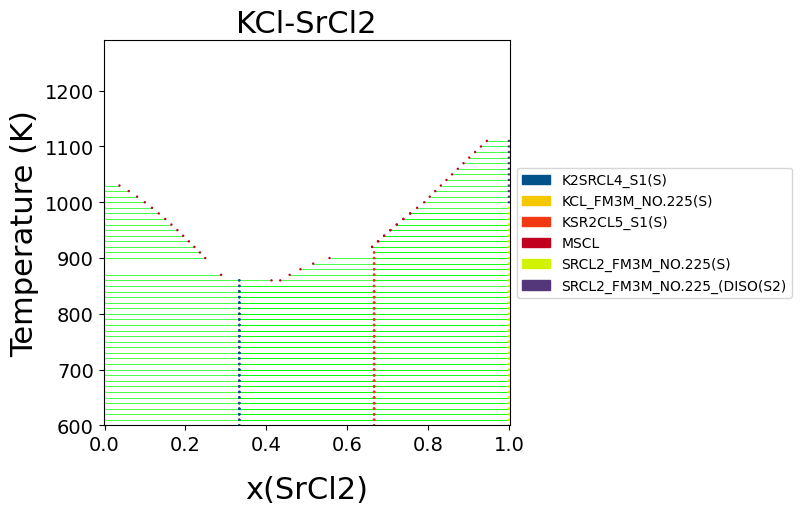

In [10]:
#Plot figure setting
fig= plt.figure(figsize=(25,5))
ax = fig.add_subplot()

#Database and condition setting
dbf = Database('BaCl2-CaCl2-SrCl2-LiCl-NaCl-KCl.xml')
comps = ['SR', 'K', 'CL']
#Filter phases
from pycalphad.core.utils import filter_phases, unpack_components
fcomps=sorted(unpack_components(dbf,comps))
phases=filter_phases(dbf, fcomps)
print(phases)

#Phase legend for plotting
def fixed_phase_legend(phases):
    legend_handles, colorlist = phase_legend(phases)
    def _dummy_phase_legend(_):
        return legend_handles, colorlist
    return _dummy_phase_legend

#Perform equilibrium calcualtions to map the whole compostion space
x_SrCl2=[0.02, 0.28, 0.39, 0.528, 0.6, 0.761, 0.96]
species={'SRCL2': {'SR':1, 'CL':2}, 'KCL': {'K':1, 'CL':1}}
eq=list()
for i in x_SrCl2:
    composition={'SRCL2':i, 'KCL':1-i}
    atomic_comp=calc_pseudo_comp(species,composition)
    conds = {v.N: 1, v.P: 101325, v.T: (600,1300,10), v.X('K'): atomic_comp['K'], v.X('SR'): atomic_comp['SR']}
    result=equilibrium(dbf, comps, phases, conds, verbose=False)
    eq.append(result)
    print(i, 'done')
    
#Plot phase diagram
phase_leg_func = fixed_phase_legend(phases)
for i in range(0, len(eq)):
    eqplot(eq[i], x=v.X('SR'), y=v.T, z=v.X('K'),legend_generator=phase_leg_func, ax=ax)

ax.set_xlim(-0.0025, 1.0025)
ax.set_xlabel('x(SrCl2)', fontsize=22)
ax.set_ylabel('Temperature (K)', fontsize=22)
ax.set_title('KCl-SrCl2', fontsize=22)
#ax.legend().remove()
plt.grid(False)
plt.show()

In [57]:
#Try to plot NaCl-SrCl2